In [1]:
import torch

def absmax_quantize(X):
    # Calculate scale
    scale = 127 / torch.max(torch.abs(X))
    #print(scale)
    # Quantize
    X_quant = (scale * X).round()

    # Dequantize
    X_dequant = X_quant / scale

    return X_quant.to(torch.int8), X_dequant

In [2]:
def zeropoint_quantize(X):
    # Calculate value range (denominator)
    x_range = torch.max(X) - torch.min(X)
    x_range = 1 if x_range == 0 else x_range

    # Calculate scale
    scale = 255 / x_range
    #print(scale)
    # Shift by zero-point
    zeropoint = (-scale * torch.min(X) - 128).round()

    # Scale and round the inputs
    X_quant = torch.clip((X * scale + zeropoint).round(), -128, 127)

    # Dequantize
    X_dequant = (X_quant - zeropoint) / scale

    return X_quant.to(torch.int8), X_dequant

In [3]:
!pip install -q bitsandbytes>=0.39.0
!pip install -q git+https://github.com/huggingface/accelerate.git
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
torch.manual_seed(0)

# Set device to CPU for now
device = 'cuda'

# Load model and tokenizer
model_id = 'gpt2'
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Print model size
print(f"Model size: {model.get_memory_footprint():,} bytes")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Model size: 510,342,192 bytes


In [5]:
# Extract weights of the first layer
weights = model.transformer.h[0].attn.c_attn.weight.data
print("Original weights:")
print(weights)

# Quantize layer using absmax quantization
weights_abs_quant, _ = absmax_quantize(weights)
print("\nAbsmax quantized weights:")
print(weights_abs_quant)

# Quantize layer using absmax quantization
weights_zp_quant, _ = zeropoint_quantize(weights)
print("\nZero-point quantized weights:")
print(weights_zp_quant)

Original weights:
tensor([[-0.4738, -0.2614, -0.0978,  ...,  0.0513, -0.0584,  0.0250],
        [ 0.0874,  0.1473,  0.2387,  ..., -0.0525, -0.0113, -0.0156],
        [ 0.0039,  0.0695,  0.3668,  ...,  0.1143,  0.0363, -0.0318],
        ...,
        [-0.2592, -0.0164,  0.1991,  ...,  0.0095, -0.0516,  0.0319],
        [ 0.1517,  0.2170,  0.1043,  ...,  0.0293, -0.0429, -0.0475],
        [-0.4100, -0.1924, -0.2400,  ..., -0.0046,  0.0070,  0.0198]],
       device='cuda:0')

Absmax quantized weights:
tensor([[-21, -12,  -4,  ...,   2,  -3,   1],
        [  4,   7,  11,  ...,  -2,  -1,  -1],
        [  0,   3,  16,  ...,   5,   2,  -1],
        ...,
        [-12,  -1,   9,  ...,   0,  -2,   1],
        [  7,  10,   5,  ...,   1,  -2,  -2],
        [-18,  -9, -11,  ...,   0,   0,   1]], device='cuda:0',
       dtype=torch.int8)

Zero-point quantized weights:
tensor([[-20, -11,  -3,  ...,   3,  -2,   2],
        [  5,   8,  12,  ...,  -1,   0,   0],
        [  1,   4,  18,  ...,   6,   3,   

In [6]:
import numpy as np
from copy import deepcopy

# Store original weights
weights = [param.data.clone() for param in model.parameters()]

# Create model to quantize
model_abs = deepcopy(model)

# Quantize all model weights
weights_abs = []
for param in model_abs.parameters():
    _, dequantized = absmax_quantize(param.data)
    param.data = dequantized
    weights_abs.append(dequantized)

# Create model to quantize
model_zp = deepcopy(model)

# Quantize all model weights
weights_zp = []
for param in model_zp.parameters():
    _, dequantized = zeropoint_quantize(param.data)
    param.data = dequantized
    weights_zp.append(dequantized)

In [7]:
weights_zp

[tensor([[-0.1078, -0.0359,  0.0359,  ..., -0.1318,  0.0120,  0.0479],
         [ 0.0359, -0.0479,  0.0479,  ...,  0.0839,  0.0000,  0.0479],
         [-0.1318,  0.0479,  0.1797,  ...,  0.0958, -0.1318, -0.0839],
         ...,
         [-0.0479, -0.0599,  0.0120,  ...,  0.1078,  0.0958, -0.0719],
         [ 0.1917,  0.0120,  0.0479,  ..., -0.0958,  0.0839, -0.0240],
         [ 0.0479, -0.0240,  0.0479,  ...,  0.0120,  0.1557,  0.1198]],
        device='cuda:0'),
 tensor([[-0.0337, -0.2024,  0.0000,  ..., -0.0337,  0.0337,  0.0675],
         [ 0.0337, -0.0675, -0.1012,  ...,  0.0337,  0.0000,  0.0000],
         [ 0.0000, -0.1012,  0.0675,  ...,  0.0337,  0.0337, -0.0337],
         ...,
         [ 0.0000,  0.0000, -0.0675,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -0.0337,  ...,  0.0337,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
        device='cuda:0'),
 tensor([0.2232, 0.1819, 0.1538, 0.1918, 0.2034, 0.1951, 0.1463, 0

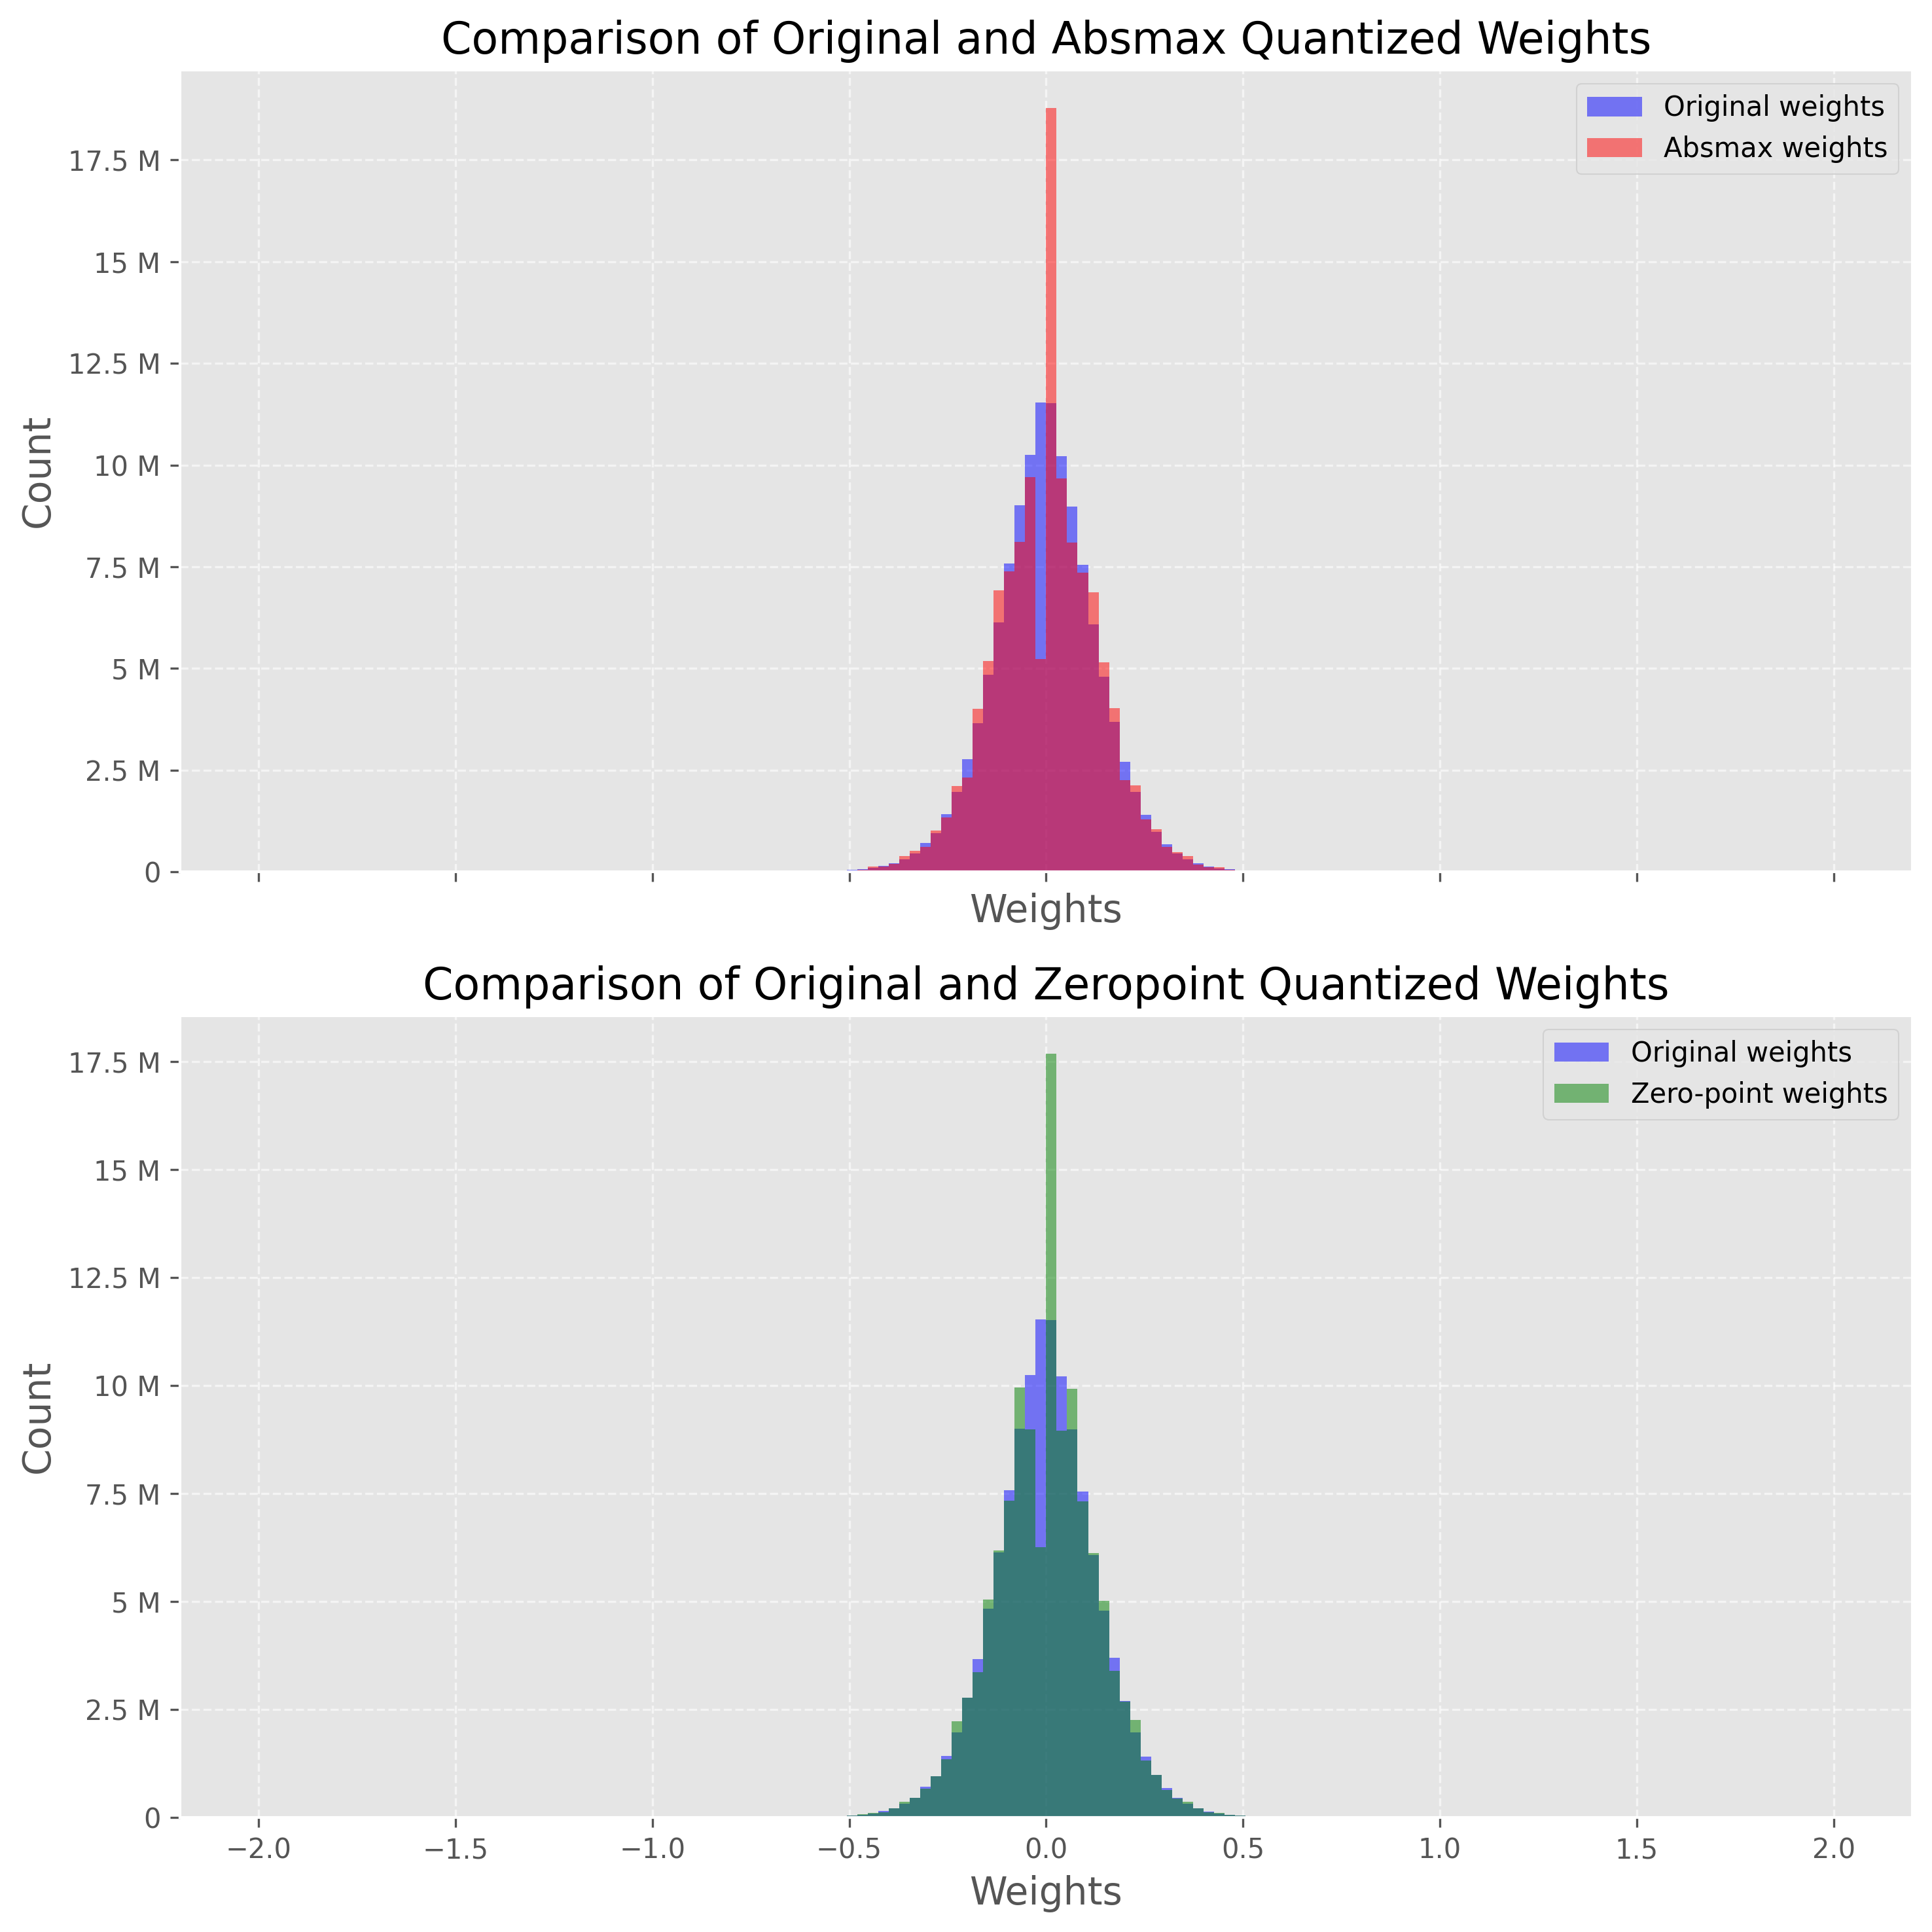

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
# Flatten weight tensors
weights = np.concatenate([t.cpu().numpy().flatten() for t in weights])
weights_abs = np.concatenate([t.cpu().numpy().flatten() for t in weights_abs])
weights_zp = np.concatenate([t.cpu().numpy().flatten() for t in weights_zp])

# Set background style
plt.style.use('ggplot')

# Create figure and axes
fig, axs = plt.subplots(2, figsize=(10,10), dpi=300, sharex=True)

# Plot the histograms for original and zero-point weights
axs[0].hist(weights, bins=150, alpha=0.5, label='Original weights', color='blue', range=(-2, 2))
axs[0].hist(weights_abs, bins=150, alpha=0.5, label='Absmax weights', color='red', range=(-2, 2))

# Plot the histograms for original and absmax weights
axs[1].hist(weights, bins=150, alpha=0.5, label='Original weights', color='blue', range=(-2, 2))
axs[1].hist(weights_zp, bins=150, alpha=0.5, label='Zero-point weights', color='green', range=(-2, 2))

# Add grid
for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.6)

# Add legend
axs[0].legend()
axs[1].legend()

# Add title and labels
axs[0].set_title('Comparison of Original and Absmax Quantized Weights', fontsize=16)
axs[1].set_title('Comparison of Original and Zeropoint Quantized Weights', fontsize=16)

for ax in axs:
    ax.set_xlabel('Weights', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.yaxis.set_major_formatter(ticker.EngFormatter()) # Make y-ticks more human readable

# Improve font
plt.rc('font', size=12)

plt.tight_layout()
plt.show()


In [10]:
def generate_text(model, input_text, max_length=50):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
    output = model.generate(inputs=input_ids,
                            max_length=max_length,
                            do_sample=True,
                            top_k=30,
                            pad_token_id=tokenizer.eos_token_id,
                            attention_mask=input_ids.new_ones(input_ids.shape))
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Generate text with original and quantized models
original_text = generate_text(model, "I have a dream")
absmax_text   = generate_text(model_abs, "I have a dream")
zp_text       = generate_text(model_zp, "I have a dream")

print(f"Original model:\n{original_text}")
print("-" * 50)
print(f"Absmax model:\n{absmax_text}")
print("-" * 50)
print(f"Zeropoint model:\n{zp_text}")

Original model:
I have a dream. I don't know what will come of it, but I am going to have to look for something that will be right. I haven't thought about it for a long time, but I have to try to get that thing
--------------------------------------------------
Absmax model:
I have a dream job.

If you can talk about your work and what you believe, then come on! I'm gonna love you!
--------------------------------------------------
Zeropoint model:
I have a dream.

I also have a dream...

That dream...


In [11]:
def calculate_perplexity(model, text):
    # Encode the text
    encodings = tokenizer(text, return_tensors='pt').to(device)

    # Define input_ids and target_ids
    input_ids = encodings.input_ids
    target_ids = input_ids.clone()

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)

    # Loss calculation
    neg_log_likelihood = outputs.loss

    # Perplexity calculation
    ppl = torch.exp(neg_log_likelihood)

    return ppl

ppl     = calculate_perplexity(model, original_text)
ppl_abs = calculate_perplexity(model_abs, absmax_text)
ppl_zp  = calculate_perplexity(model_zp, absmax_text)

print(f"Original perplexity: {ppl.item():.2f}")
print(f"Absmax perplexity:   {ppl_abs.item():.2f}")
print(f"Zeropoint perplexity: {ppl_zp.item():.2f}")

Original perplexity: 7.94
Absmax perplexity:   21.84
Zeropoint perplexity: 21.32


In [ ]:
# перезапустить сеанс

In [ ]:
!pip install transformers==4.31.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.48.0.dev0
    Uninstalling transformers-4.48.0.dev0:
      Successfully uninstalled transformers-4.48.0.dev0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.3.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.31.0 which is incompatible.


In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q datasets
!pip install -q einops


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 11.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = "gpt2-large"


tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, device_map={"":0})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2-large and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task t

In [ ]:
print(f"Model size: {model.get_memory_footprint():,} bytes")

Model size: 3,133,869,200 bytes


In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q datasets
!pip install -q einops

In [ ]:


import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = "gpt2-large"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True
    #,
    #bnb_4bit_use_double_quant=True,
    #bnb_4bit_quant_type="nf4",
    #bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
model_in_4bit = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, trust_remote_code=True, device_map={"":0})

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2-large and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: `.to` is not supported for `4-bit` or `8-bit` models. Please use the model as it is, since the model has already been set to the correct devices and casted to the correct `dtype`.

In [ ]:
print(f"Model size: {model_in_4bit.get_memory_footprint():,} bytes")

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = "gpt2-large"
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
model_in_8bit = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, trust_remote_code=True, device_map={"":0})

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2-large and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(f"Model size: {model_in_8bit.get_memory_footprint():,} bytes")

Model size: 878,020,168 bytes


In [ ]:
device = 'cuda'
def generate_text(model, input_text, max_length=50):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
    output = model.generate(inputs=input_ids,
                            max_length=max_length,
                            do_sample=True,
                            top_k=30,
                            pad_token_id=tokenizer.eos_token_id,
                            attention_mask=input_ids.new_ones(input_ids.shape))
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Generate text with original and quantized models
original_text = generate_text(model, "I have a dream")
absmax_text   = generate_text(model_in_8bit, "I have a dream")
#zp_text       = generate_text(model_in_4bit, "I have a dream")

print(f"Original model:\n{original_text}")
print("-" * 50)
print(f"Absmax model:\n{absmax_text}")
print("-" * 50)
#print(f"Zeropoint model:\n{zp_text}")

Original model:
I have a dream" and he said "yeah" and you know I was just really impressed. But he asked me to say it in a certain way and I didn't want to say that he should have the power. So he said, "
--------------------------------------------------
Absmax model:
I have a dream. My dream is not to become a billionaire and, if I become wealthy, I want to donate to social justice causes. I do not want to be part of an upper class, privileged white society. My dream is to become
--------------------------------------------------


In [ ]:
model_16 = AutoModelForCausalLM.from_pretrained("gpt2-large", torch_dtype=torch.float16)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
print(f"Model size: {model_16.get_memory_footprint():,} bytes")

Model size: 1,585,808,968 bytes


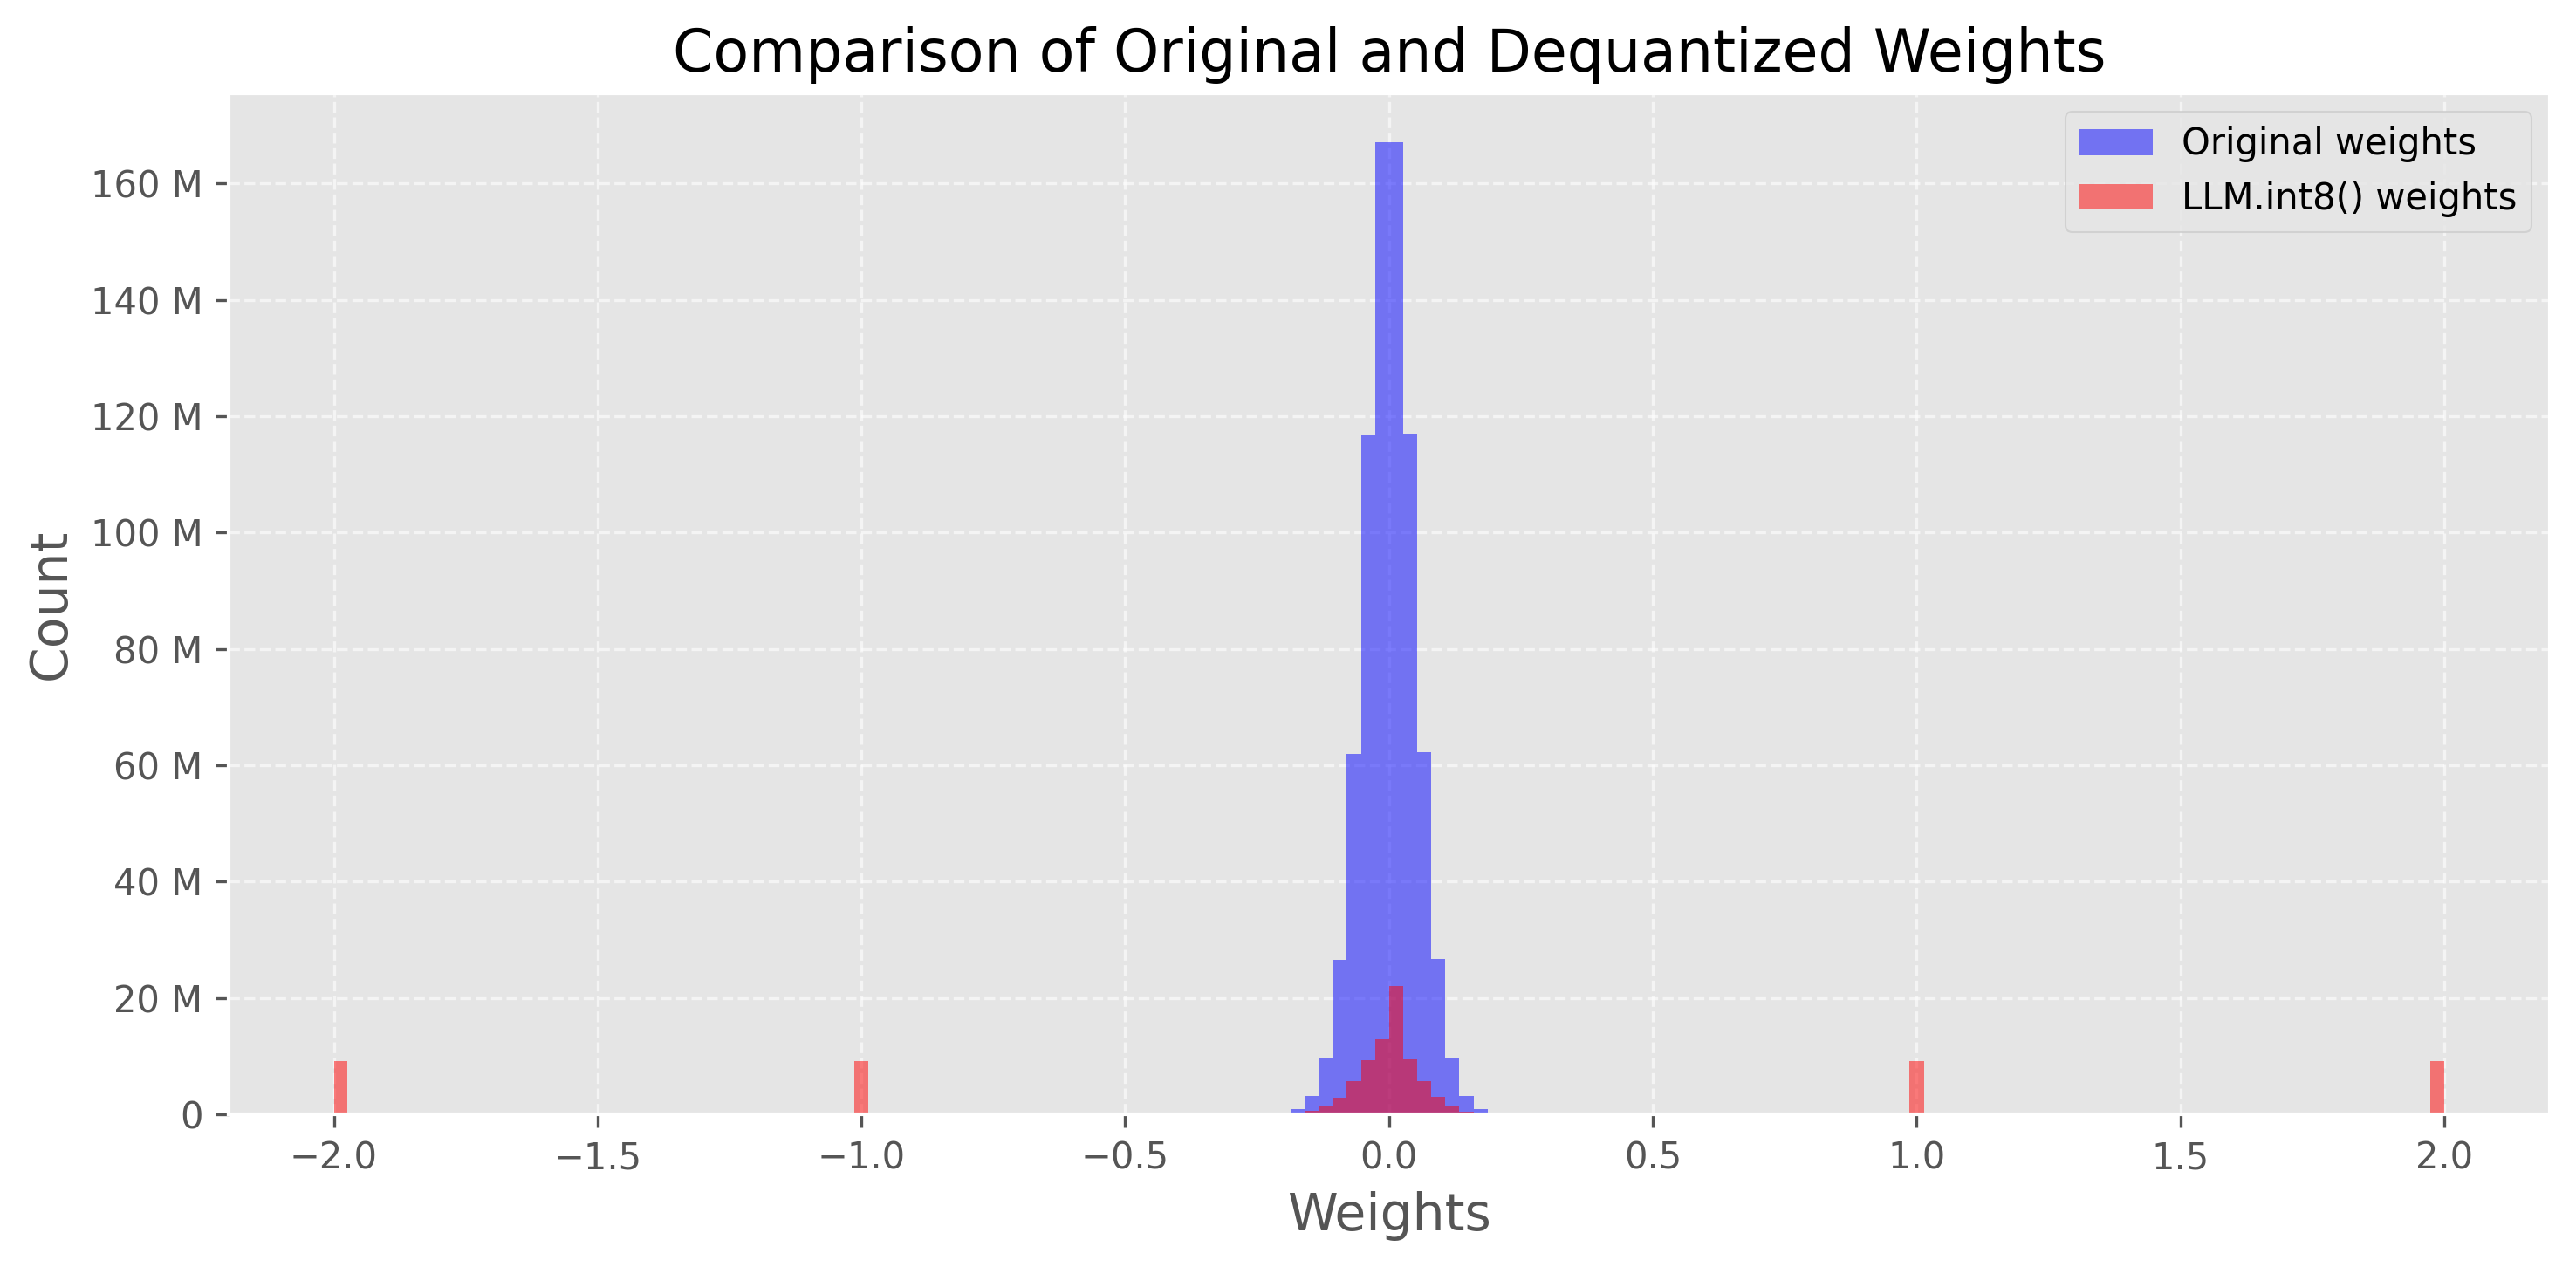

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
# Flatten weight tensors
weights_float16 = [param.data.clone() for param in model_in_8bit.parameters()]
weights_float16 = np.concatenate([t.cpu().numpy().flatten() for t in weights_float16])

weights = [param.data.clone() for param in model.parameters()]
weights = np.concatenate([t.cpu().numpy().flatten() for t in weights])
# Set background style
plt.style.use('ggplot')

# Create figure and axis
fig, ax = plt.subplots(figsize=(10,5), dpi=300)

# Plot the histograms
ax.hist(weights, bins=150, alpha=0.5, label='Original weights',
        color='blue', range=(-2, 2))
ax.hist(weights_float16, bins=150, alpha=0.5, label='LLM.int8() weights',
        color='red', range=(-2, 2))

# Add grid
ax.grid(True, linestyle='--', alpha=0.6)

# Add legend
ax.legend()

# Add title and labels
ax.set_title('Comparison of Original and Dequantized Weights', fontsize=16)
ax.set_xlabel('Weights', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
plt.gca().yaxis.set_major_formatter(ticker.EngFormatter())

# Improve font
plt.rc('font', size=12)

plt.tight_layout()
plt.show()